---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./apples_pears.csv")

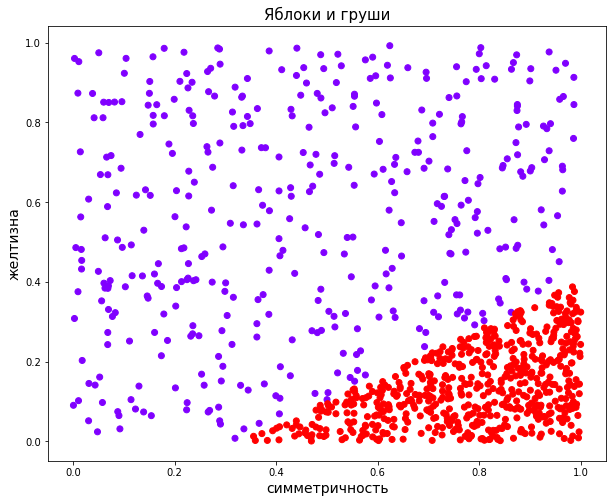

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [4]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [5]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [6]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [7]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [9]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.4078], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

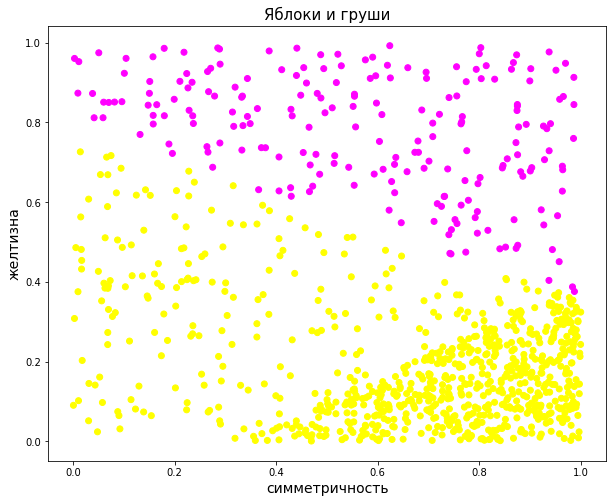

In [10]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [11]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [25]:
# квадратичная функция потерь (можно сделать другую, например, LogLoss)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.0001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(50000):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    # print('{} {}'.format(t, loss.data))

    # обнуляем градиенты перед backard_pass'ом (обязательно!)
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

Обучили. Предскажем теперь:

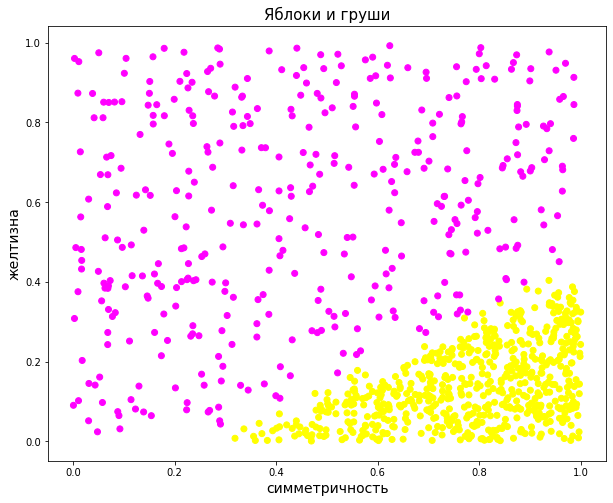

In [26]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()`(==logloss) или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

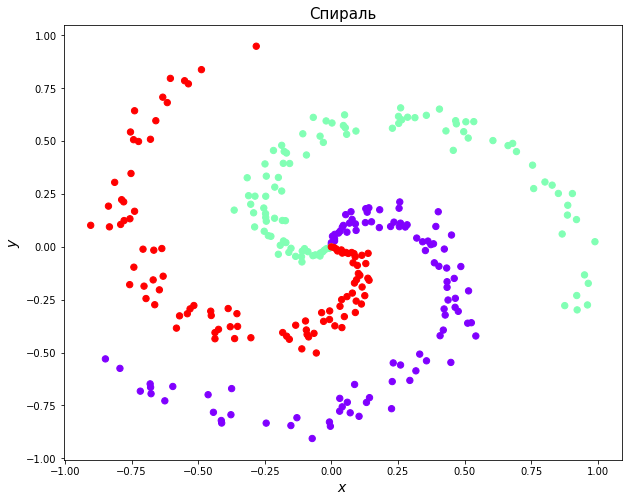

In [13]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable():

In [14]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [15]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем нейрон с сигмоидой на линейно неразделимой выборке (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [16]:
# N - размер батча (batch_size, нужно для метода оптимизации)
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

c:\users\izakharkin\anaconda3\envs\vision\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 357.8382263183594
1 357.4598388671875
2 357.083251953125
3 356.7077941894531
4 356.3343200683594
5 355.9619140625
6 355.59130859375
7 355.2218933105469
8 354.85430908203125
9 354.48785400390625
10 354.1230163574219
11 353.75958251953125
12 353.3976135253906
13 353.0369567871094
14 352.6777038574219
15 352.31982421875
16 351.9635314941406
17 351.6083679199219
18 351.2549133300781
19 350.9024963378906
20 350.55157470703125
21 350.2019348144531
22 349.8537292480469
23 349.5068359375
24 349.1611022949219
25 348.8169250488281
26 348.47381591796875
27 348.1322326660156
28 347.7916259765625
29 347.4527587890625
30 347.1150207519531
31 346.77838134765625
32 346.44305419921875
33 346.10888671875
34 345.7760009765625
35 345.4446105957031
36 345.11419677734375
37 344.78509521484375
38 344.4571533203125
39 344.1304931640625
40 343.80499267578125
41 343.4803771972656
42 343.15753173828125
43 342.83538818359375
44 342.5147705078125
45 342.1949462890625
46 341.8767395019531
47 341.5594177246094
48 

In [17]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

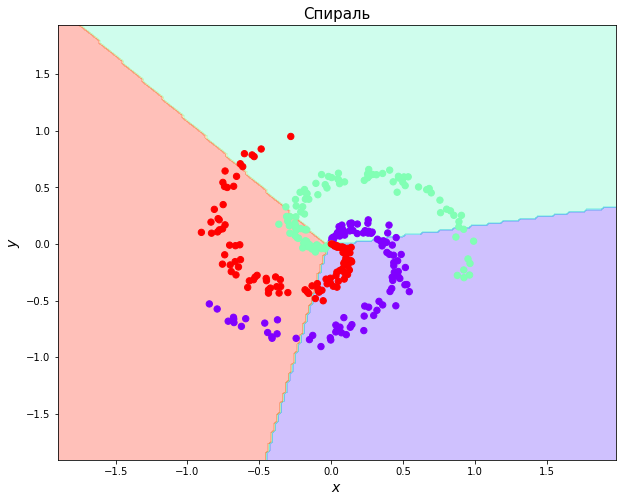

In [18]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слищком впечатляет. В следующей практике мы попробуем многослойную нейросеть на этой же задаче.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*